# Custom Models in BoTorch
In this tutorial, we illustrate how to create a custom surrogate model using the [`Model`](https://github.com/pytorch/botorch/blob/main/botorch/models/model.py) and [`Posterior`](https://github.com/pytorch/botorch/blob/main/botorch/posteriors/posterior.py) interface. We will cover creating surrogate models from: PyTorch distributions, Posterior samples (using Pyro), and an Ensemble of ML predictions.

In [1]:
import torch

torch.manual_seed(1)
train_X = torch.rand(20, 2) * 2
Y = 1 - (train_X - 0.5).norm(dim=-1, keepdim=True)
Y += 0.1 * torch.rand_like(Y)
bounds = torch.stack([torch.zeros(2), 2 * torch.ones(2)])

Code to plot our data setup.

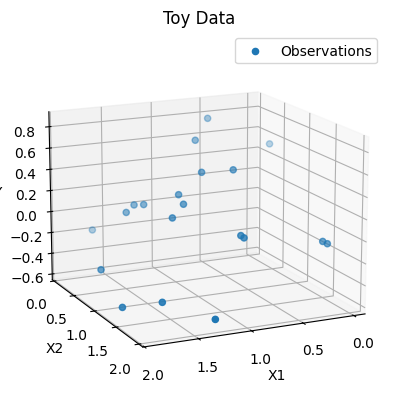

In [2]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from torch import Tensor


def plot_toy_data(x: Tensor, y: Tensor) -> Axes:
    ax = plt.figure().add_subplot(projection="3d")
    ax.scatter(
        x[:, 0].detach().numpy().squeeze(),
        x[:, 1].detach().numpy().squeeze(),
        zs=y.detach().numpy().squeeze(),
        label="Observations",
    )
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("Y")
    ax.set_title("Toy Data")
    ax.view_init(elev=15.0, azim=65, roll=0)
    ax.legend()
    return ax


plot_toy_data(x=train_X, y=Y)
plt.show()

## Probabilistic Linear Regression (w/ Torch Distributions)
BoTorch's `Model` class only requires you to define a `posterior()` method that returns a `Posterior` object, the only requirement of which is to implement an `rsample()` function for drawing posterior samples. Specifically, we can utilize the subclass [`TorchPosterior`](https://github.com/pytorch/botorch/blob/main/botorch/posteriors/torch.py) that directly wraps a [torch distribution](https://pytorch.org/docs/stable/distributions.html).

In [3]:
from typing import Optional, Union
from torch import Tensor, distributions, nn
from botorch.acquisition.objective import PosteriorTransform
from botorch.models.model import Model
from botorch.posteriors.posterior import Posterior
from botorch.posteriors.torch import TorchPosterior


class ProbabilisticRegressionModel(Model):
    _num_outputs: int

    def __init__(self, train_X: Tensor, train_Y: Tensor):
        super(ProbabilisticRegressionModel, self).__init__()
        self._num_outputs = train_Y.shape[-1]
        # Linear layer that will compute the regression output.
        self.linear = nn.Linear(train_X.shape[-1], self.num_outputs)

    @property
    def num_outputs(self) -> int:
        return self._num_outputs

    def forward(self, x: Tensor) -> distributions.Distribution:
        n, p = x.squeeze().shape
        # For now, lets suppose we have known variance 1.
        return distributions.StudentT(df=n - p, loc=self.linear(x), scale=1)

    def posterior(
        self,
        X: Tensor,
        output_indices: Optional[list[int]] = None,
        observation_noise: Union[bool, Tensor] = False,
        posterior_transform: Optional[PosteriorTransform] = None,
    ) -> Posterior:
        if output_indices:
            X = X[..., output_indices]
        posterior = TorchPosterior(distribution=self(X))
        if posterior_transform:
            posterior = posterior_transform(posterior)
        return posterior

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


Although we chose `StudentT` distribution above, any distribution supporting the `rsample` method will work with BoTorch's automatic differentiation. We can use the `has_rsample` attribute to see a complete listing of compatible distributions.

In [4]:
print(
    [
        j.__name__
        for j in [getattr(distributions, i) for i in distributions.__all__]
        if hasattr(j, "has_rsample") and j.has_rsample
    ]
)

['Beta', 'Cauchy', 'Chi2', 'ContinuousBernoulli', 'Dirichlet', 'Exponential', 'FisherSnedecor', 'Gamma', 'Gumbel', 'HalfCauchy', 'HalfNormal', 'Independent', 'InverseGamma', 'Kumaraswamy', 'Laplace', 'LogNormal', 'LogisticNormal', 'LowRankMultivariateNormal', 'MultivariateNormal', 'Normal', 'OneHotCategoricalStraightThrough', 'Pareto', 'RelaxedBernoulli', 'RelaxedOneHotCategorical', 'StudentT', 'Uniform', 'Weibull', 'Wishart', 'TransformedDistribution']


In [5]:
def fit_prob_reg(
    epochs: int,
    model: ProbabilisticRegressionModel,
    optimizer: torch.optim.Optimizer,
    train_X: Tensor,
    train_Y: Tensor,
) -> None:
    """Optimization loop for linear regression."""
    train_X = train_X.requires_grad_()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_X)
        loss = -outputs.log_prob(train_Y).mean()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print("epoch {}, loss {}".format(epoch, loss.item()))

In [6]:
prob_regression_model = ProbabilisticRegressionModel(train_X, Y)
optimizer = torch.optim.Adam(prob_regression_model.parameters(), lr=0.1)
fit_prob_reg(50, prob_regression_model, optimizer, train_X, Y)

epoch 0, loss 1.1335891485214233
epoch 10, loss 0.9871206283569336
epoch 20, loss 0.9712644815444946
epoch 30, loss 0.9583339691162109
epoch 40, loss 0.957848846912384


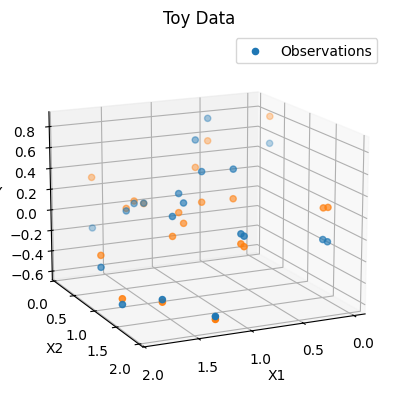

In [7]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=prob_regression_model(train_X).mean.detach().squeeze().numpy(),
)
plt.show()

Finally, we can use both analytic and MC based acquisition functions.

In [8]:
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim.optimize import optimize_acqf

optimize_acqf(
    LogExpectedImprovement(model=prob_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-0.1540))

Before using `qLogExpectedImprovement` we need to register an appropriate sampler for the `TorchPosterior`. We can use the following code to create a `MCSampler` for any subclass of `torch.distributions.Distribution`.

In [9]:
from botorch.sampling.base import MCSampler
from botorch.sampling.get_sampler import GetSampler
from botorch.sampling.stochastic_samplers import StochasticSampler


@GetSampler.register(distributions.Distribution)
def _get_sampler_torch(
    posterior: TorchPosterior,
    sample_shape: torch.Size,
    *,
    seed: Optional[int] = None,
) -> MCSampler:
    return StochasticSampler(sample_shape=sample_shape, seed=seed)

In [10]:
from botorch.acquisition.logei import qLogExpectedImprovement

optimize_acqf(
    qLogExpectedImprovement(model=prob_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0.0000, 0.1162]]), tensor(-0.3718))

## Bayesian Linear Regression
In the previous section, we directly parameterized a "posterior" with a linear layer. In this section, we will follow Chapter 14.2 of [Bayesian Data Analysis](https://stat.columbia.edu/~gelman/book/) to implement a *proper* posterior analytically. This implementation also uses `TorchPosterior` and the `StudentT` distribution like before.

In [11]:
from typing import Optional, Union
from torch import Tensor, distributions, nn
from botorch.acquisition.objective import PosteriorTransform
from botorch.models.model import Model
from botorch.posteriors.posterior import Posterior
from botorch.posteriors.torch import TorchPosterior


def add_intercept(x: Tensor) -> Tensor:
    """Adds an intercept column to the design matrix (i.e. tensor)."""
    return torch.concat([torch.ones_like(x)[..., 0:1], x], dim=-1)


class BayesianRegressionModel(Model):
    _num_outputs: int
    df: int
    s_squared: Tensor
    beta: Tensor
    V: Tensor
    add_intercept: bool

    def __init__(self, intercept: bool = True) -> None:
        super(BayesianRegressionModel, self).__init__()
        self.add_intercept = intercept

    @property
    def num_outputs(self) -> int:
        return self._num_outputs

    def forward(self, x: Tensor) -> Tensor:
        return x @ self.beta

    def fit(self, x: Tensor, y: Tensor) -> None:
        self._num_outputs = y.shape[-1]
        x = add_intercept(x) if self.add_intercept else x
        n, p = x.shape
        self.df = n - p
        # Inverse of the gram matrix.
        self.V = torch.linalg.inv(x.T @ x)
        # Least squares estimate
        self.beta = self.V @ x.T @ y
        # Model's residuals from the labels.
        r: Tensor = y - self(x)
        # Sample variance
        self.s_squared = (1 / self.df) * r.T @ r

    def posterior(
        self,
        X: Tensor,
        output_indices: Optional[list[int]] = None,
        observation_noise: Union[bool, Tensor] = False,
        posterior_transform: Optional[PosteriorTransform] = None,
    ) -> Posterior:
        # Squeeze out the q dimension if needed.
        n, q, _ = X.shape
        if output_indices:
            X = X[..., output_indices]
        if self.add_intercept:
            X = add_intercept(X)
        loc = self(X)
        # Full covariance matrix of all test points.
        cov = self.s_squared * (torch.eye(n, n) + X.squeeze() @ self.V @ X.squeeze().T)
        # The batch semantics of BoTorch evaluate each data point in their own batch.
        # So, we extract the diagonal representing Var[\tilde y_i | y_i] of each test point.
        scale = torch.diag(cov).reshape(n, q, self.num_outputs)
        # Form the posterior predictive dist according to Sec 14.2, Pg 357 of BDA.
        posterior_predictive_dist = distributions.StudentT(
            df=self.df, loc=loc, scale=scale
        )
        posterior = TorchPosterior(distribution=posterior_predictive_dist)
        if posterior_transform:
            posterior = posterior_transform(posterior)
        return posterior

In [12]:
bayesian_regression_model = BayesianRegressionModel(intercept= True)
bayesian_regression_model.fit(train_X, Y)

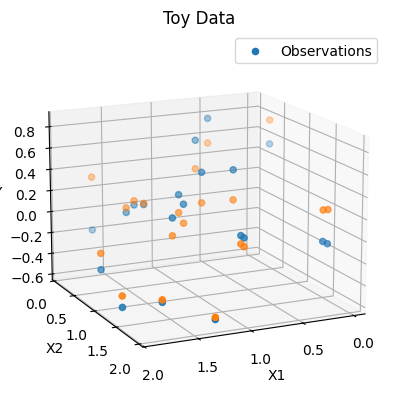

In [13]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=bayesian_regression_model(add_intercept(train_X)).detach().squeeze().numpy(),
)
plt.show()

In [14]:
optimize_acqf(
    LogExpectedImprovement(model=bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-1.3416))

In [15]:
optimize_acqf(
    qLogExpectedImprovement(model=bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-1.3211))

## Bayesian Linear Regression w/ `EnsemblePosterior`
The `EnsemblePosterior` class provides an implementation for `posterior()`. Then the MC acquisition function will be optimized using samples from the posterior predictive distribution (`EnsemblePosterior` also implements `mean` and `variance` properties, so some other analytic acquisition functions will also work). We follow this [Pyro tutorial](https://pyro.ai/examples/bayesian_regression.html#Bayesian-Regression-with-Pyro%E2%80%99s-Stochastic-Variational-Inference-(SVI)) for a linear regression model fit with [Stochastic Variational Inference](https://pyro.ai/examples/svi_part_i.html) (SVI). Importantly, **SVI is differentiable** allowing us to use gradient information to optimize the acquisition function.

In [16]:
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoGuide, AutoDiagonalNormal
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import PyroOptim

pyro.set_rng_seed(1)

# Bayesian Regression represented as a single hidden layer.
class BayesianRegression(PyroModule):
    Y: str = "y"

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        # Linear layer like before, but wrapped with PyroModule.
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # Add priors to the weights & bias of the linear layer.
        self.linear.weight = PyroSample(
            dist.Normal(0.0, 1.0)
            .expand(torch.Size([out_features, in_features]))
            .to_event(2)
        )
        self.linear.bias = PyroSample(
            dist.Normal(0.0, 10.0).expand(torch.Size([out_features])).to_event(1)
        )

    def forward(self, x: Tensor, y: Optional[Tensor] = None) -> Tensor:
        # Prior for the noise level.
        sigma = pyro.sample("sigma", dist.Uniform(0.0, 10.0))
        # Linear layer on the inputs.
        mean = self.linear(x).squeeze(-1)
        n, p = x.shape[0], x.shape[-1]
        with pyro.plate("data", x.shape[0]):
            # Observations will be t distributed.
            t_dist = dist.StudentT(df=n - p, loc=mean, scale=sigma)
            _ = pyro.sample(self.Y, t_dist, obs=y)
        return mean

In [17]:
def fit_svi(
    epochs: int,
    model: PyroModule,
    guide: AutoGuide,
    optimizer: PyroOptim,
    train_X: Tensor,
    train_Y: Tensor,
) -> None:
    svi = SVI(
        model,
        guide,
        optimizer,
        loss=Trace_ELBO(),
    )
    pyro.clear_param_store()
    for epoch in range(epochs):
        loss = svi.step(train_X, train_Y.squeeze())
        if epoch % 10 == 0:
            print("epoch {}, loss {}".format(epoch, loss))

We need to ensure [`Predictive`](https://github.com/pyro-ppl/pyro/blob/dev/pyro/infer/predictive.py) supports gradients **which requires us to monkey patch** to the pyro library.

In [18]:
import pyro.poutine as poutine
from pyro.poutine.util import prune_subsample_sites
from pyro.infer.predictive import (
    _guess_max_plate_nesting,
    _predictive_vectorize_plate_name,
    _predictive_sequential,
    _predictiveResults,
)


def _predictive(
    model,
    posterior_samples,
    num_samples,
    return_sites=(),
    parallel=False,
    model_args=(),
    model_kwargs={},
    mask=True,
):
    ###########################################################################
    # Remove the torch.no_grad() here. Originally, this is:
    # model = torch.no_grad()(poutine.mask(model, mask=False) if mask else model)
    ###########################################################################
    model = poutine.mask(model, mask=False) if mask else model
    ###########################################################################
    max_plate_nesting = _guess_max_plate_nesting(model, model_args, model_kwargs)
    vectorize = pyro.plate(
        _predictive_vectorize_plate_name, num_samples, dim=-max_plate_nesting - 1
    )
    model_trace = prune_subsample_sites(
        poutine.trace(model).get_trace(*model_args, **model_kwargs)
    )
    reshaped_samples = {}

    for name, sample in posterior_samples.items():
        sample_shape = sample.shape[1:]
        sample = sample.reshape(
            (num_samples,)
            + (1,) * (max_plate_nesting - len(sample_shape))
            + sample_shape
        )
        reshaped_samples[name] = sample

    return_site_shapes = {}
    for site in model_trace.stochastic_nodes + model_trace.observation_nodes:
        append_ndim = max_plate_nesting - len(model_trace.nodes[site]["fn"].batch_shape)
        site_shape = (
            (num_samples,) + (1,) * append_ndim + model_trace.nodes[site]["value"].shape
        )
        # non-empty return-sites
        if return_sites:
            if site in return_sites:
                return_site_shapes[site] = site_shape
        # special case (for guides): include all sites
        elif return_sites is None:
            return_site_shapes[site] = site_shape
        # default case: return sites = ()
        # include all sites not in posterior samples
        elif site not in posterior_samples:
            return_site_shapes[site] = site_shape

    # handle _RETURN site
    if return_sites is not None and "_RETURN" in return_sites:
        value = model_trace.nodes["_RETURN"]["value"]
        shape = (num_samples,) + value.shape if torch.is_tensor(value) else None
        return_site_shapes["_RETURN"] = shape

    if not parallel:
        return _predictive_sequential(
            model,
            posterior_samples,
            model_args,
            model_kwargs,
            num_samples,
            return_site_shapes,
        )

    trace = poutine.trace(
        poutine.condition(vectorize(model), reshaped_samples)
    ).get_trace(*model_args, **model_kwargs)
    predictions = {}
    for site, shape in return_site_shapes.items():
        value = trace.nodes[site]["value"]
        if site == "_RETURN" and shape is None:
            predictions[site] = value
            continue
        if value.numel() < reduce((lambda x, y: x * y), shape):
            predictions[site] = value.expand(shape)
        else:
            predictions[site] = value.reshape(shape)

    return _predictiveResults(trace=trace, samples=predictions)


# Monkey patch in the change at the module scope.
from pyro.infer import predictive


predictive._predictive = _predictive
from pyro.infer import Predictive

In [19]:
from botorch.models.ensemble import EnsembleModel


class EnsembleBayesianRegressionModel(EnsembleModel):
    model: BayesianRegression
    guide: AutoGuide
    num_samples: int
    _num_outputs: int

    def __init__(self, train_X: Tensor, train_Y: Tensor, num_samples: int = 100):
        super(EnsembleBayesianRegressionModel, self).__init__()
        self._num_outputs = train_Y.shape[-1]
        self.model = BayesianRegression(train_X.shape[-1], self.num_outputs)
        self.guide = AutoDiagonalNormal(self.model)
        self.num_samples = num_samples

    def forward(self, X: Tensor) -> Tensor:
        predictive = Predictive(
            self.model,
            guide=self.guide,
            num_samples=self.num_samples,
            # Only return the posterior predictive distribution for y.
            return_sites=(self.model.Y,),
        )
        # `EnsemblePosterior` expects a `(b) x s x q x m` tensor where `m` is the
        # output size of the model and `s` is the ensemble size.
        samples = (
            # Retrieve posterior samples from the observation random variable.
            # This is also known as a posterior predictive distribution.
            predictive(X.squeeze())[self.model.Y]
            # Move the ensemble dimension to "s" axis.
            .transpose(0, 1)
            # Reshape for `EnsemblePosterior` as mentioned above.
            .reshape(X.shape[0], -1, 1, self.num_outputs)
        )
        return samples

In [20]:
ensemble_bayesian_regression_model = EnsembleBayesianRegressionModel(
    train_X=train_X, train_Y=Y
)
fit_svi(
    100,
    ensemble_bayesian_regression_model.model,
    ensemble_bayesian_regression_model.guide,
    pyro.optim.Adam({"lr": 0.1}),
    train_X,
    Y,
)

epoch 0, loss 64.95897650718689
epoch 10, loss 33.78854823112488
epoch 20, loss 34.89813268184662
epoch 30, loss 28.840062141418457
epoch 40, loss 17.356289327144623
epoch 50, loss 33.069618701934814
epoch 60, loss 19.79256308078766
epoch 70, loss 33.51183533668518
epoch 80, loss 22.71115493774414
epoch 90, loss 22.114057540893555


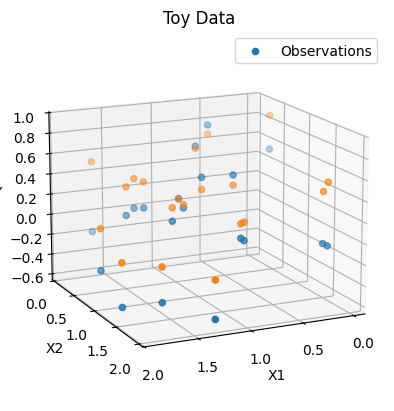

In [21]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=ensemble_bayesian_regression_model(train_X)
    .detach()
    .squeeze()
    .mean(dim=-1)
    .numpy(),
)
plt.show()

In [22]:
optimize_acqf(
    LogExpectedImprovement(model=ensemble_bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-0.5977))

In [23]:
optimize_acqf(
    qLogExpectedImprovement(model=ensemble_bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-0.6397))

## Random Forest w/ Ensemble Posterior
Lastly, we move away from linear models to any ML technique that ensembles many models. Specifically, the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) from sklearn.

In [24]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from botorch.models.ensemble import EnsembleModel


class EnsembleRandomForestModel(EnsembleModel):
    model: RandomForestRegressor
    num_samples: int
    _num_outputs: int

    def __init__(self, num_samples: int = 100):
        super(EnsembleRandomForestModel, self).__init__()
        self._num_outputs = 1
        self.model = RandomForestRegressor(n_estimators=num_samples)

    def fit(self, X: Tensor, y: Tensor) -> None:
        self.model = self.model.fit(
            X=X.detach().numpy(), y=y.detach().numpy().squeeze()
        )

    def forward(self, X: Tensor) -> Tensor:
        x = X.detach().numpy().squeeze()
        # Create the ensemble from predictions from each decision tree.
        y = torch.from_numpy(np.array([i.predict(x) for i in self.model.estimators_]))
        # `EnsemblePosterior` expects a `(b) x s x q x m` tensor where `m` is the
        # output size of the model and `s` is the ensemble size.
        samples = y.transpose(0, 1).reshape(X.shape[0], -1, 1, self.num_outputs)
        return samples

In [25]:
ensemble_random_forest_model = EnsembleRandomForestModel(num_samples=300)
ensemble_random_forest_model.fit(X=train_X, y=Y)

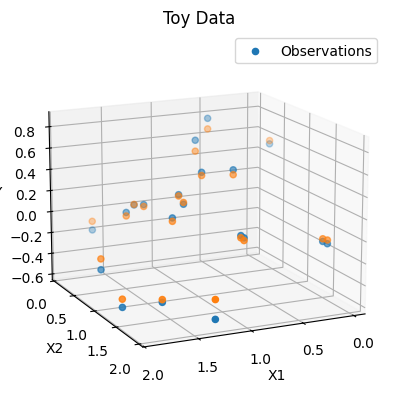

In [26]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=ensemble_random_forest_model(train_X).detach().squeeze().mean(dim=-1).numpy(),
)
plt.show()

In order to use gradient-based optimization of the acquisition function (via the standard `optimize_acqf()` method) we will need to have the samples drawn from the posterior be differentiable w.r.t. to the input to the `posterior()` method (this is not the case for Random Forest models). Instead, we will perform the acquisition function optimization with gradient-free methods.

In [27]:
optimize_acqf(
    LogExpectedImprovement(model=ensemble_random_forest_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
    options={"with_grad": False},
)

(tensor([[0.3431, 0.0144]]), tensor(-3.5971, dtype=torch.float64))

In [28]:
optimize_acqf(
    qLogExpectedImprovement(model=ensemble_random_forest_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
    options={"with_grad": False},
)

(tensor([[0.8587, 0.0292]]), tensor(-14.7641, dtype=torch.float64))

### CMA-ES
We can also move the optimization loop out of BoTorch entirely and follow the [CMA-ES tutorial](https://botorch.org/tutorials/optimize_with_cmaes) to optimize with an evolution strategy.

In [29]:
import cma
import numpy as np

x0 = np.random.rand(2)

es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.2,
    inopts={"bounds": [0, 2], "popsize": 50},
)

log_expected_improvement_ensemble_random_forest_model = LogExpectedImprovement(
    model=ensemble_random_forest_model, best_f=Y.max()
)

with torch.no_grad():
    while not es.stop():
        xs = es.ask()
        y = (
            -log_expected_improvement_ensemble_random_forest_model(
                torch.from_numpy(np.array(xs)).unsqueeze(-2)
            )
            .view(-1)
            .double()
            .numpy()
        )
        es.tell(xs, y)

torch.from_numpy(es.best.x)

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=301897, Mon Aug 19 21:13:12 2024)


tensor([0.7640, 0.1918], dtype=torch.float64)